# BS/MS Solutions Analysis

First, we import necessary libraries to do the analysis:

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import scipy
import scipy.integrate
import scipy.optimize

Define initial known parameters:

In [2]:
T = 473.        # isothermal reactor temperature, K
R = 8.314       # gas constant, J/mol/K
Ca0 = 100.      # initial feed concentration, mole/m3
v0 = 2.       # initial volumetric flowrate, m3/min
Fa0 = Ca0 * v0  # initial molar flowrate, mole/min

Price_a = 200.  # Price of reactant A (buy and sell price), $/kmol
Price_b = 300.  # Sell price of intermediate B, $/kmol
Price_r = 1000. # Sell price of product R, $/kmol
Cost_SQ = 5.    # Cost of separating undesired S & Q, $/mol


Then, define the rate constants as provided by Company ABC:

In [3]:
def k1(T):
    A = 0.05  # min^-1
    Ea = 6000. # J
    return A*np.exp(-1*Ea / R / T)

def k2(T):
    A = 1.0    # m3/mol/min
    Ea = 12500. # J
    return A*np.exp(-1*Ea / R / T)

def k3(T):
    A = 0.08  # min^-1
    Ea = 7000. # J
    return A*np.exp(-1*Ea / R / T)

def k4(T):
    A = 0.06  # min^-1
    Ea = 9000. # J
    return A*np.exp(-1*Ea / R / T)

In [4]:
#Testing of rate constants at our desired reactor temperature

print(k1(473))
print(k2(473))
print(k3(473))
print(k4(473))

0.0108730207535
0.0416430096589
0.0134906715351
0.00608445340136


This function defines the first order differential equation that will be solved in the subsequent steps:

In [5]:
def dFdV(F,V):
    # unpack values from Fsol vector into five variables
    Fa, Fb, Fr, Fs, Fq = F  

    # Total molar flowrate:
    Ft = Fa + Fb + Fr + Fs + Fq
    
    # Total concentration, from ideal gas law:
    Ct = 100. #mol/m3
    
    # Concentrations:
    Ca = Ct * (Fa / Ft)
    Cb = Ct * (Fb / Ft)
    Cr = Ct * (Fr / Ft)
    Cs = Ct * (Fs / Ft)
    Cq = Ct * (Fq / Ft)
    
    # rates of progress of reactions
    r1 = k1(T) * Ca
    r2 = k2(T) * Cb**2
    r3 = k3(T) * Cb
    r4 = k4(T) * Cb
    
    # rates of generation of species
    ra = -r1
    rb = r1 - (r2 + r3 + r4)
    rr = r2
    rs = r3
    rq = r4
    
    # Differential equations
    dFadV = ra
    dFbdV = rb
    dFrdV = rr
    dFsdV = rs
    dFqdV = rq
    
    return[dFadV,dFbdV,dFrdV,dFsdV,dFqdV]

Define the range of reactor volumes we would like to sweep across (trial and error in figuring out suitable range):

In [6]:
V = np.linspace(0,1000.,num=2000)

Pack five variables into the initial condition:

In [7]:
F0 = [Fa0,0,0,0,0]

Solve the ODE and unpack the variables:

In [8]:
Y_result = scipy.integrate.odeint(dFdV, F0, V)
Fa, Fb, Fr, Fs, Fq = Y_result.T

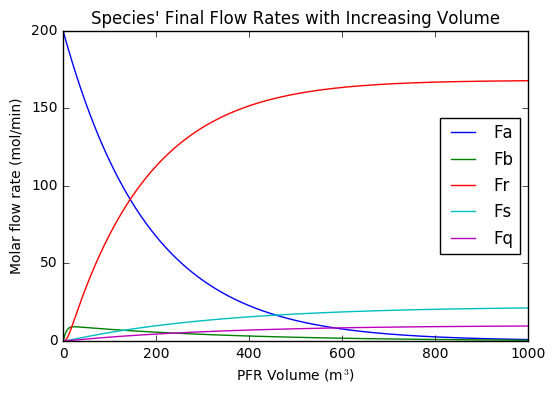

In [9]:
plt.plot(V, Fa, label='Fa')
plt.plot(V, Fb, label='Fb')
plt.plot(V, Fr, label='Fr')
plt.plot(V, Fs, label='Fs')
plt.plot(V, Fq, label='Fq')
plt.legend(loc="best")
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Molar flow rate (mol/min)')
plt.title('Species\' Final Flow Rates with Increasing Volume')
plt.savefig("flows", bbox_inches='tight')
plt.show()

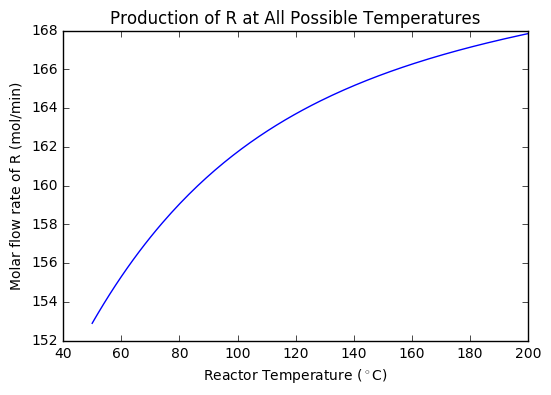

In [10]:
final_r=[]
Trange = np.linspace(323,473,150)
for i in Trange:
    T = i
    solution=scipy.integrate.odeint(dFdV,F0,V)
    Fa, Fb, Fr, Fs, Fq = solution.T
    final_r.append(Fr[-1])

plt.plot(Trange-273, final_r)
plt.xlabel('Reactor Temperature ($^\circ$C)')
plt.ylabel('Molar flow rate of R (mol/min)')
plt.title('Production of R at All Possible Temperatures')
plt.savefig("temperature", bbox_inches='tight')
plt.show()

In [11]:
P_a = Price_a * Fa0/1000.
Prec_a = Price_a * Fa/1000.
P_b = Price_b * Fb/1000.
P_r = Price_r * Fr/1000.
P_s = Cost_SQ * Fs
P_q = Cost_SQ * Fq
P_tot = (P_r + Prec_a + P_b) - (P_a + P_s + P_q)

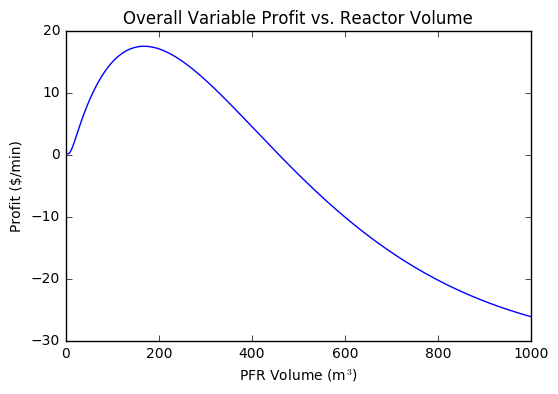

In [12]:
plt.plot(V, P_tot)
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Profit ($/min)')
plt.title('Overall Variable Profit vs. Reactor Volume')
plt.savefig("profit", bbox_inches='tight')
plt.show()

In [13]:
max_y = np.max(P_tot)
max_x = V[np.argmax(P_tot)]

print("The max profit is ${:5.2f}/min.".format(max_y))
print("This occurs at reactor volume %.2f m3." %max_x)
annual_profit = max_y * 60 * 24 * 5 * 50
print("The max annual profit is ${:8.2f}.".format(annual_profit))

The max profit is $17.52/min.
This occurs at reactor volume 168.08 m3.
The max annual profit is $6306931.67.


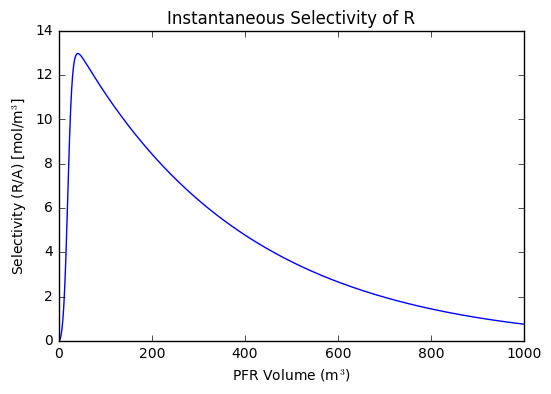

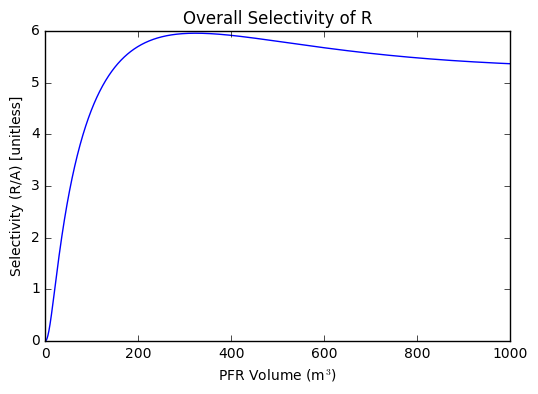

In [14]:
Cb = Fb/v0
Ca = Fa/v0

instselectivity = k2(473)* Cb**2/(k1(473)* Ca - k2(473) * Cb**2)
ovrselectivity = Fr[1:]/(Fs[1:] + Fq[1:]+ Fb[1:])

plt.plot(V, instselectivity)
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Selectivity (R/A) [mol/m$^3$]')
plt.title('Instantaneous Selectivity of R')
plt.savefig("inst selectivity", bbox_inches='tight')
plt.show()

plt.plot(V[1:], ovrselectivity)
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Selectivity (R/A) [unitless]')
plt.title('Overall Selectivity of R')
plt.savefig("ovr selectivity", bbox_inches='tight')
plt.show()

In [15]:
max_instselectivity = np.max(instselectivity)
max_Vinstselect = V[np.argmax(instselectivity)]

max_ovrselectivity = np.max(ovrselectivity)
max_Vovrselect = V[np.argmax(ovrselectivity)]

 
print("For instantaneous selectivity:")
print("The maximum selectivity of the desired to the undesired is {:5.2f}.".format(max_instselectivity))
print("This occurs at a reactor volume of {:5.2f} m3.".format(max_Vinstselect))

print("\nFor overall selectivity:")
print("The maximum selectivity of the desired to the undesired is {:5.2f}.".format(max_ovrselectivity))
print("This occurs at a reactor volume of {:5.2f} m3.".format(max_Vovrselect))

For instantaneous selectivity:
The maximum selectivity of the desired to the undesired is 12.98.
This occurs at a reactor volume of 41.02 m3.

For overall selectivity:
The maximum selectivity of the desired to the undesired is  5.96.
This occurs at a reactor volume of 322.66 m3.


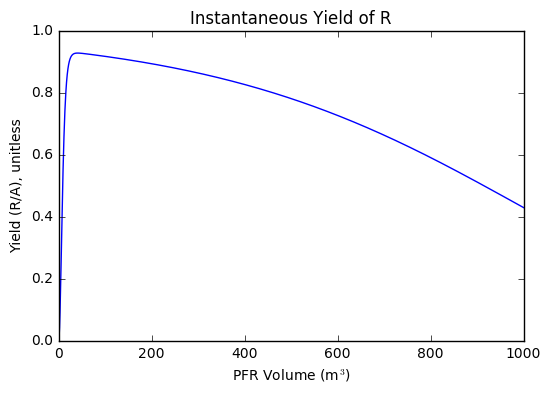

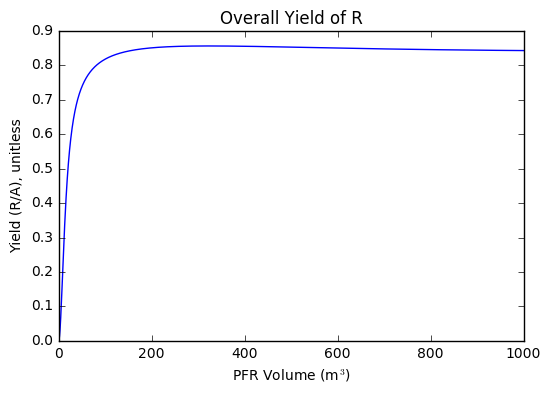

In [16]:
instyield = k2(473.)/k1(473.) * (Cb**2/Ca)
ovryield = Fr[1:]/(Fa0-Fa[1:])

plt.plot(V, instyield)
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Yield (R/A), unitless')
plt.title('Instantaneous Yield of R')
plt.savefig("inst yield", bbox_inches='tight')
plt.show()

plt.plot(V[1:], ovryield)
plt.xlabel('PFR Volume (m$^3$)')
plt.ylabel('Yield (R/A), unitless')
plt.title('Overall Yield of R')
plt.savefig("ovr yield", bbox_inches='tight')
plt.show()

In [17]:
max_instyield = np.max(instyield)
max_Vinstyield = V[np.argmax(instyield)]

max_ovryield = np.max(ovryield)
max_Vovryield = V[np.argmax(ovryield)]

print("For instantaneous yield:")
print("The maximum yield is {:05.3f}, which occurs at a reactor volume of {:05.2f} m3.".format(max_instyield,max_Vinstyield))

print("\nFor overall yield:")
print("The maximum yield is {:05.3f}, which occurs at a reactor volume of {:05.2f} m3.".format(max_ovryield,max_Vovryield))

For instantaneous yield:
The maximum yield is 0.928, which occurs at a reactor volume of 41.02 m3.

For overall yield:
The maximum yield is 0.856, which occurs at a reactor volume of 322.66 m3.
